# Dynamic method comparison - GAD noise for multi-copy case


In [4]:
import time
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm


import quairkit as qkit
from quairkit import Circuit
from quairkit import to_state
from quairkit.database import *
from quairkit.loss import *
from quairkit.qinfo import *
from quairkit.database.hamiltonian import ising_hamiltonian
from quairkit.ansatz import *
from quairkit.operator import ParamOracle

qkit.set_dtype('complex128')



## Dynamic LOCCNet 

In [5]:
def simcir2(n):
    cir = Circuit(2*n)
    cir.ry() 
    cir.cnot([2,0])
    cir.cnot([3,1])
    cir.ry(qubits_idx=[2,3])
    cir.cnot([0,2])
    cir.cnot([1,3])

    return cir

In [6]:
def loss_func3(cir1, cir2, cir3, target_state, noisy_state):
    
    # first round LOCCNet
    input_state1 = torch.kron(noisy_state,noisy_state)
    state1 = cir1(to_state(input_state1))
    measure_state = Measure('z'* 2)
    _, m_state = measure_state(state1, qubits_idx=list(range(2,4)),keep_state=True,desired_result='0'*2)
    output_state1 = partial_trace(m_state,1,[4,4]).density_matrix
    
    input_state2 = torch.kron(output_state1,noisy_state)
    state2 = cir2(to_state(input_state2))
    _, m_state2 = measure_state(state2, qubits_idx=list(range(2,4)),keep_state=True,desired_result='0'*2)
    output_state2 = partial_trace(m_state2,1,[4,4]).density_matrix
    
    input_state3 = torch.kron(output_state2,noisy_state)
    state3 = cir3(to_state(input_state3))
    _, m_state3 = measure_state(state3, qubits_idx=list(range(2,4)),keep_state=True,desired_result='0'*2)
    output_state = partial_trace(m_state3,1,[4,4]).density_matrix
 
    f = state_fidelity(target_state,output_state).item()**2
    loss = 1-state_fidelity(target_state,output_state)**2
    
    return loss, output_state,f

In [7]:
def train_model_fix3(num_itr, LR, n, target_state,noisy_state):
    
    loss_list, time_list = [], []
    
    cir1 = simcir2(n)
    cir2 = simcir2(n)
    cir3 = simcir2(n)
    
    opt_cir1 = torch.optim.Adam(lr=LR, params=cir1.parameters()) # cir is a Circuit type
    opt_cir2 = torch.optim.Adam(lr=LR, params=cir2.parameters()) # cir is a Circuit type
    opt_cir3 = torch.optim.Adam(lr=LR, params=cir3.parameters()) # cir is a Circuit type
    scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_cir1, 'min', factor=0.5) # activate scheduler
    scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_cir2, 'min', factor=0.5) # activate scheduler
    scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_cir3, 'min', factor=0.5) # activate scheduler

    
    
    print('Training:')
    
    for itr in range(num_itr):
        start_time = time.time()
        opt_cir1.zero_grad()
        opt_cir2.zero_grad()
        opt_cir3.zero_grad()
        
        loss, output_state3,_ = loss_func3(cir1, cir2, cir3, target_state, noisy_state) # compute loss
        loss.backward()
        opt_cir1.step()
        opt_cir2.step()
        opt_cir3.step()
        scheduler1.step(loss) # activate scheduler
        scheduler2.step(loss)
        scheduler3.step(loss)
        
        loss = loss.item()
        loss_list.append(loss)
        time_list.append(time.time() - start_time)
        
        if itr % 500 == 0 or itr == num_itr - 1:
            print(
                f"iter: {itr}, loss: {loss:.8f}, lr: {scheduler1.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s"
            )
            time_list = []
            
    # cir1.plot('detailed')
    # cir2.plot('detailed')
    # cir3.plot('detailed')
    output_state = output_state3.detach()
    fid = state_fidelity(output_state,target_state).item()**2
    
    return fid
    
    # fid_dynamic.append(fid.item()**2)

## DEJMPS

In [8]:
def dejmps(n):
    cir = Circuit(2*n)
    cir.rx(param=np.pi/2,qubits_idx=[0,2]) 
    cir.rx(param=-np.pi/2,qubits_idx=[1,3])
    for i in range(2):
        cir.cnot([i,i+2])
    
    return cir

# Train

In [ ]:
n = 2
NUM_ITR = 1500
LR = 0.1
target_state = bell_state(2).density_matrix

fid_s = []

fid_dynamic = []
fid_de = []
fid_no1 = []
fid_fixed = []
cir_de1 = dejmps(n)
cir_dyn = simcir2(n)



I = torch.tensor([[1, 0],
                [0, 1]],
            dtype=torch.cdouble)
for q1 in range(1,10):
    for p1 in range(1,10):
        q = q1/10
        p = p1/10
        E0 = math.sqrt(q)*torch.tensor([[1, 0],
                        [0, math.sqrt(p)]],
                        dtype=torch.cdouble)
        E1 = math.sqrt(q)*torch.tensor([[0, math.sqrt(1-p)],
                        [0, 0]],
                        dtype=torch.cdouble)
        E2 = math.sqrt(1-q)*torch.tensor([[math.sqrt(p),0],
                        [0, 1]],
                        dtype=torch.cdouble)
        E3 = math.sqrt(1-q)*torch.tensor([[0,0],
                        [math.sqrt(1-p), 0]],
                        dtype=torch.cdouble)
        
        K = [torch.kron(Ei, I) for Ei in (E0, E1, E2, E3)]
        # noisy state
        state_ad = sum(Ki @ bell_state(2).density_matrix @ Ki.conj().T for Ki in K)
        fid1 = state_fidelity(state_ad,target_state).item()**2
        fid_no1.append(fid1)

        ######## dynamic dejmps ################
        _, _, fde3 = loss_func3(cir_de1, cir_de1, cir_de1, target_state, state_ad)
        fid_de.append(fde3)
        ######## dynamic loccnet ################
        ffix3 = train_model_fix3(NUM_ITR, LR, n, target_state, state_ad)
        fid_fixed.append(ffix3)   

        print('coefficient q',q)
        print('parameter p',p)

Training:
iter: 0, loss: 0.71893001, lr: 1.00E-01, avg_time: 0.0549s
iter: 500, loss: 0.56688862, lr: 1.19E-08, avg_time: 0.0040s
iter: 1000, loss: 0.56688862, lr: 1.19E-08, avg_time: 0.0042s
iter: 1499, loss: 0.56688862, lr: 1.19E-08, avg_time: 0.0042s
coefficient q 0.1
parameter p 0.1
Training:
iter: 0, loss: 0.66615325, lr: 1.00E-01, avg_time: 0.0040s
iter: 500, loss: 0.42175075, lr: 1.19E-08, avg_time: 0.0052s
iter: 1000, loss: 0.42175076, lr: 1.19E-08, avg_time: 0.0042s
iter: 1499, loss: 0.42175075, lr: 1.19E-08, avg_time: 0.0047s
coefficient q 0.1
parameter p 0.2
Training:
iter: 0, loss: 0.72846081, lr: 1.00E-01, avg_time: 0.0043s
iter: 500, loss: 0.40114171, lr: 1.19E-08, avg_time: 0.0043s
iter: 1000, loss: 0.40114170, lr: 1.19E-08, avg_time: 0.0045s
iter: 1499, loss: 0.40114171, lr: 1.19E-08, avg_time: 0.0041s
coefficient q 0.1
parameter p 0.3
Training:
iter: 0, loss: 0.38860301, lr: 1.00E-01, avg_time: 0.0039s
iter: 500, loss: 0.28371685, lr: 1.19E-08, avg_time: 0.0040s
iter: 

## Data and Plot

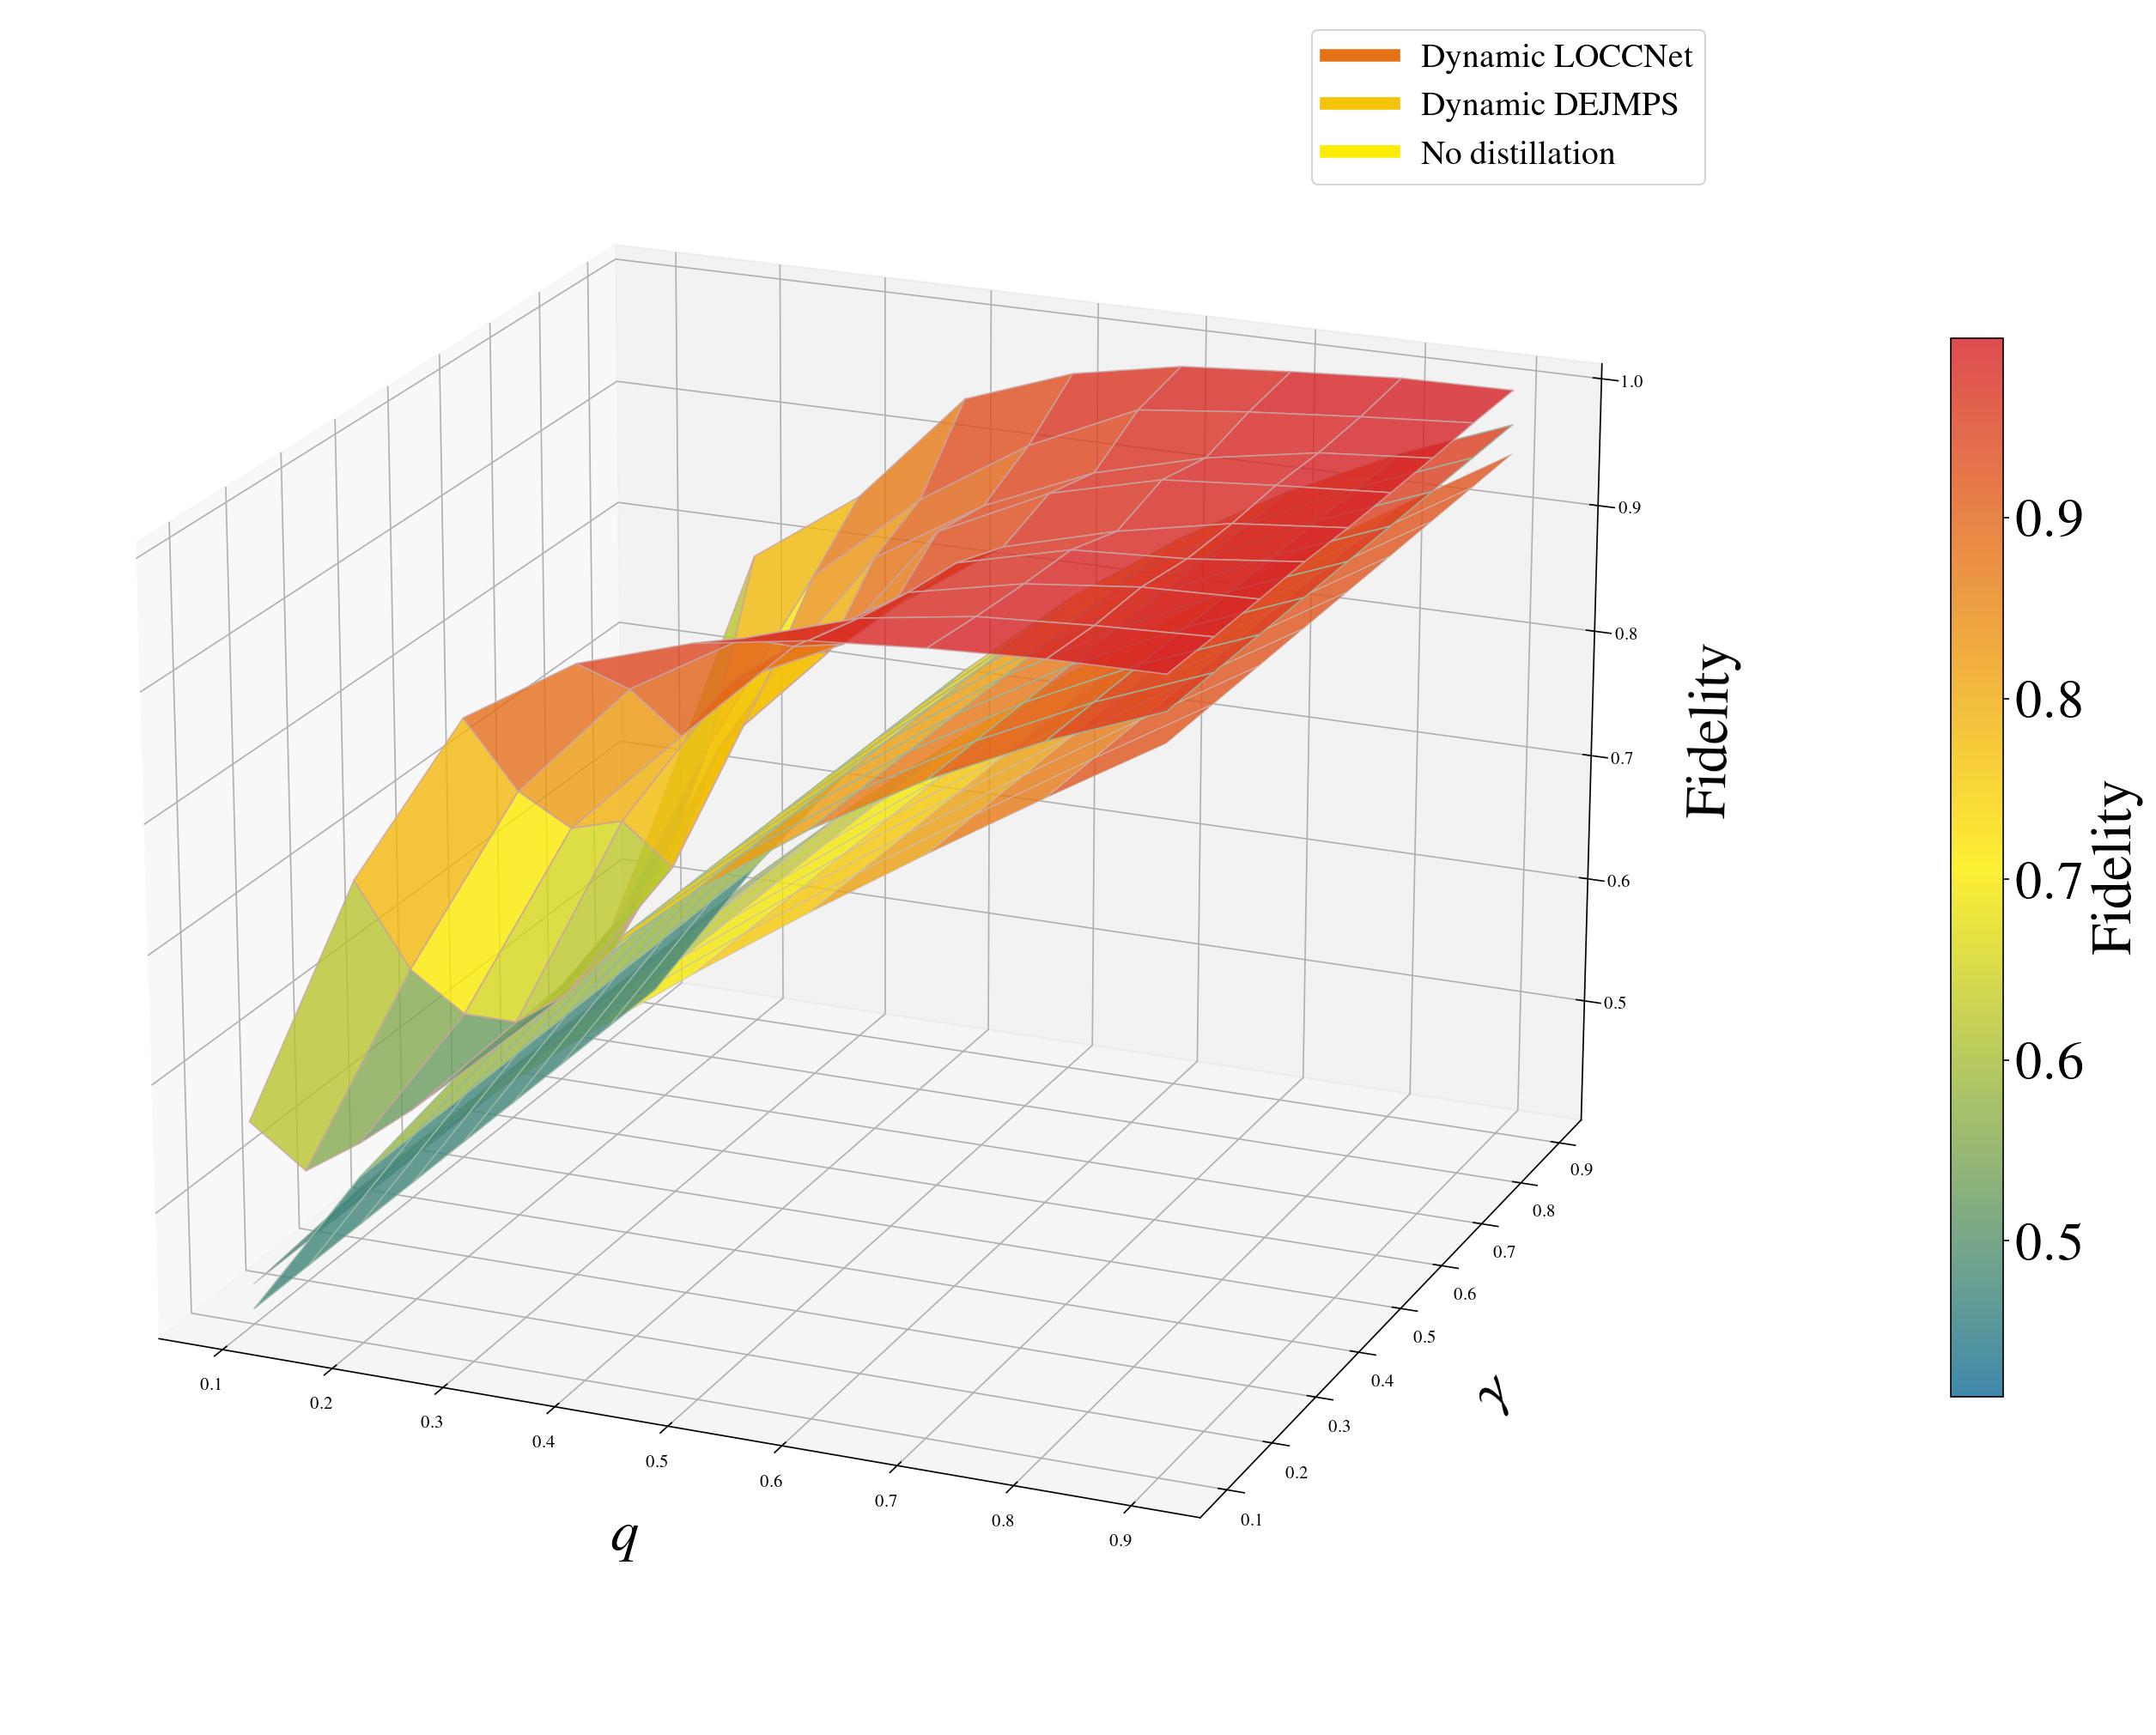

In [ ]:
plt.rcParams.update({
    "text.usetex": True,   
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{newtxtext}\usepackage{newtxmath}"
})

plt.rcParams['legend.fontsize'] = 70

q_range = np.arange(1, 10) 
p_range = np.arange(1, 10)  
Q, P = np.meshgrid(q_range/10, p_range/10)

# dynamic DEJMPS
fid_de =  [0.4137044003634879, 0.5318224158298585, 0.6330670652167166, 0.7184465054721327, 0.7897231396599432, 0.8489598220808104, 0.8980863560553005, 0.9387586777417694, 0.9723524454047424, 0.4137044003634879, 0.531822405108867, 0.6330670535196629, 0.7184464978068821, 0.7897231544548258, 0.8489598220808104, 0.8980863699872114, 0.9387586979659376, 0.9723524432821611, 0.4137044003634879, 0.5318224136503543, 0.6330670535196629, 0.7184464877795631, 0.7897231382853693, 0.8489598220808104, 0.8980863616038747, 0.9387586777417698, 0.9723524432821611, 0.41370440036348805, 0.531822405108867, 0.6330670535196629, 0.7184465054721325, 0.7897231541247642, 0.8489598220808109, 0.8980863724437755, 0.9387586919856598, 0.9723524454047426, 0.41370439371492945, 0.5318224051088668, 0.6330670535196631, 0.7184464877795635, 0.7897231484987189, 0.8489598277678727, 0.8980863560553012, 0.9387586979659378, 0.9723524432821611, 0.4137043973373197, 0.531822412419272, 0.6330670535196629, 0.718446495532018, 0.7897231359053726, 0.8489598085353057, 0.8980863560553012, 0.9387586777417696, 0.9723524309760697, 0.4137043937149296, 0.5318224051088671, 0.6330670535196629, 0.7184464964925625, 0.7897231510557555, 0.848959808535306, 0.8980863560553007, 0.9387586777417696, 0.9723524481922445, 0.4137044031706953, 0.5318224051088671, 0.6330670622909088, 0.7184464978068817, 0.7897231465821418, 0.8489598085353057, 0.8980863560553012, 0.9387586777417694, 0.9723524481922448, 0.4137043937149299, 0.5318224203310525, 0.6330670652167164, 0.7184464877795631, 0.7897231510557552, 0.8489598085353061, 0.8980863758365057, 0.9387586777417694, 0.9723524562291351]
# no distillation
fid_no1 =  [0.43311388711409954, 0.5236067994157129, 0.5988612823986932, 0.6662277678465078, 0.7285533919414388, 0.7872983358962704, 0.8433300247688995, 0.8972136067249987, 0.9493416593621791, 0.4331138929468479, 0.5236068026477942, 0.5988612799688875, 0.6662277703037089, 0.7285533911054057, 0.78729835369656, 0.8433300287930886, 0.8972135999044173, 0.9493416505053003, 0.4331138899488676, 0.5236067984010435, 0.5988612792168997, 0.6662277773990286, 0.7285534025179311, 0.7872983431479218, 0.8433300273265362, 0.8972136061132342, 0.9493416639627146, 0.4331138965088982, 0.523606798184143, 0.5988612917540298, 0.6662277716337383, 0.7285534029128063, 0.7872983481975718, 0.8433300146436977, 0.8972135960682855, 0.9493416502287169, 0.4331138834032871, 0.5236068088264426, 0.5988612906338474, 0.6662277665065738, 0.7285533911054056, 0.7872983351531202, 0.8433300153213567, 0.8972136158751016, 0.9493416496554279, 0.4331138868335369, 0.52360680159965, 0.5988612905996368, 0.6662277797300504, 0.7285534013662832, 0.7872983379877421, 0.8433300170842886, 0.8972136154407626, 0.9493416679991928, 0.4331138902388747, 0.5236068072610472, 0.5988612880973796, 0.6662277669773777, 0.7285534050759191, 0.7872983482565521, 0.8433300138180359, 0.897213596068286, 0.9493416733750458, 0.4331138894058079, 0.5236068002067558, 0.5988612792168998, 0.6662277710325439, 0.7285534089229437, 0.7872983461179843, 0.8433300228809784, 0.8972136084824643, 0.9493416617886196, 0.4331138834032872, 0.523606798184143, 0.5988612792169, 0.6662277665065748, 0.7285533911054057, 0.7872983352545238, 0.8433300198489279, 0.8972136000386082, 0.949341649609861]
# dynamic loccnet
fid_fixed = [0.5607919974185793, 0.7603092941138416, 0.8953140334071964, 0.9477434622090279, 0.9743873849883341, 0.988111412217768, 0.9944349181243131, 0.9983661913574524, 0.9993167713426173,  0.48923442214357465,  0.6611930617275368,  0.8111135303333885, 0.9006009253641811, 0.9504903380974754, 0.9770960197837943,0.9899092909265568, 0.995040676119662, 0.998543567929909, 0.47821132821216905,  0.5950750808292709, 0.7532885949978222, 0.8365056973355468, 0.9166807867083123, 0.9689250575044488,  0.986811105882398,0.995926604689305, 0.9986374961051998, 0.4724206313697533, 0.5571574425687388,  0.7293631713451081, 0.8496938189828501,0.8905638409329987,  0.9640008255030408, 0.9851821740524213,0.9898978163165567,  0.9991550854597605,  0.47071679032930774, 0.5481270352550972, 0.6628432233304483, 0.8446046912222428, 0.8901530561187598,0.9492570533177415, 0.972463797949551, 0.9896916912273404, 0.9977635878054065, 0.4724485066752787, 0.5550256945876998, 0.730502992430502,0.8166661333105544, 0.9229782229095668, 0.9637931621234077, 0.9853655958000711, 0.9921910502817392, 0.9978301510944318, 0.4782301266141721, 0.5905713852068564,0.7532889664526975, 0.8640538119508557, 0.9166091870595512, 0.953508455492337,  0.9762488727732399, 0.9911341600143995,  0.9981063894140785,0.4892716076410426, 0.6612463954858941, 0.811114183067997,  0.8840248987990591,  0.9379679094534037,  0.9770852295233652, 0.9862791607173089, 0.9933527370934824, 0.9994404903105472,0.5551214352234887,0.7889551621909007, 0.8488579856752878, 0.9389059899713235, 0.9697842846680088, 0.9861622109291248,  0.9927286180300053, 0.9982358318019633, 0.9994363753906873]

fid_dynamic = np.array(fid_fixed).reshape(9,9)
fid_de = np.array(fid_de).reshape(9,9)
fid_no1 = np.array(fid_no1).reshape(9,9)


fig = plt.figure(figsize=(18, 14), dpi=150)
ax = fig.add_subplot(111, projection='3d')

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.labelsize": 24,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
})

jet_cmap = plt.get_cmap(LinearSegmentedColormap.from_list('custom', ["#116c97", "#fdec00", "#D62026"]))

vmin = min(fid_de.min(), fid_dynamic.min(), fid_no1.min())
vmax = max(fid_de.max(), fid_dynamic.max(), fid_no1.max())
norm = Normalize(vmin=vmin, vmax=vmax)

surf1 = ax.plot_surface(Q, P, fid_de, cmap=jet_cmap, norm=norm, alpha=0.8, linewidth=0.8, edgecolor="#9BB9A3",label='fid_de')
surf2 = ax.plot_surface(Q, P, fid_dynamic, cmap=jet_cmap, norm=norm, alpha=0.8, linewidth=0.8, edgecolor="#CBA5A5",label='fid_dynamic')
surf3 = ax.plot_surface(Q, P, fid_no1, cmap=jet_cmap, norm=norm, alpha=0.8, linewidth=0.5, edgecolor="#C9BFBF",label='fid_no1')

cbar = fig.colorbar(surf1, ax=ax, shrink=0.6, aspect=20, pad=0.1)
cbar.set_label('Fidelity', fontsize=32)
cbar.ax.tick_params(labelsize=30)

ax.set_xlabel('$q$', fontsize=32, labelpad=24)
ax.set_ylabel('$\gamma$', fontsize=32, labelpad=24)
ax.set_zlabel('Fidelity', fontsize=32, labelpad=24)

ax.view_init(elev=20, azim=-67)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=jet_cmap(0.8), lw=7, label='Dynamic LOCCNet'),
    Line2D([0], [0], color=jet_cmap(0.6), lw=7, label='Dynamic DEJMPS'),
    Line2D([0], [0], color=jet_cmap(0.5), lw=7, label='No distillation'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=19)

ax.grid(True, linestyle='--', alpha=0.8, linewidth=0.8)
plt.tight_layout()
plt.show()